In [ ]:
! pip install xarray[complete]

In [ ]:
! pip install rioxarray geopandas cartopy

In [1]:
# importing required libraries
import matplotlib.pyplot as plt
import urllib.request
import xarray as xr
import geopandas as gpd
import rioxarray
import cartopy.crs as ccrs
import calendar

In [ ]:
# downloading data from NOAA
for yr in range(2013,2024):
  url = f'https://downloads.psl.noaa.gov/Datasets/cpc_global_precip/precip.{yr}.nc'

  savename = url.split('/')[-1]
  savename = urllib.request.urlretrieve(url,savename)

In [2]:
# checking one of the datasets
ds2023 = xr.open_dataset('precip.2023.nc')

In [3]:
# checking out the dataset for 2023
ds2023

<xarray.Dataset> Size: 378MB
Dimensions:  (lat: 360, lon: 720, time: 365)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
Data variables:
    precip   (time, lat, lon) float32 378MB ...
Attributes:
    Conventions:    CF-1.0
    version:        V1.0
    title:          CPC GLOBAL PRCP V1.0 RT
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...
    dataset_title:  CPC GLOBAL PRCP V1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    history:        Updated 2024-01-02 23:30:47

In [6]:
# read shapefile for EU border
shapefile = gpd.read_file('europeShapeFile\Europe_NUTS_0_Demographics_and_Boundaries.shp')

In [7]:
# Check if the dataset has a CRS
print(ds2023.rio.crs)

None


In [8]:
# check the CRS for the shapefile
print(shapefile.crs)

EPSG:4326


In [9]:
# Give the same CRS of the shapefile to the dataset
ds2023 = ds2023.rio.write_crs("EPSG:4326", inplace=True)

In [10]:
# check to make sure both dataset and shapefile have the same CRS
print(f'dataset CRS: {ds2023.rio.crs}')
print(f'shapefile CRS: {shapefile.crs}')

dataset CRS: EPSG:4326
shapefile CRS: EPSG:4326


In [11]:
# Check boundaries of them
print("Dataset bounds after reprojection:", ds2023.rio.bounds())
print("Shapefile bounds after reprojection:", shapefile.total_bounds)

Dataset bounds after reprojection: (0.0, -90.0, 360.0, 90.0)
Shapefile bounds after reprojection: [-31.2688072   27.63773989  69.021886    81.856988  ]


In [12]:
# Clip the dataset using the shapefile to change its coverage from global to the Europe
ds2023_eu = ds2023.rio.clip(shapefile.geometry, shapefile.crs)

In [13]:
# Group by month and sum precipitation
ds2023_eu_mon = ds2023_eu.groupby('time.month').sum()

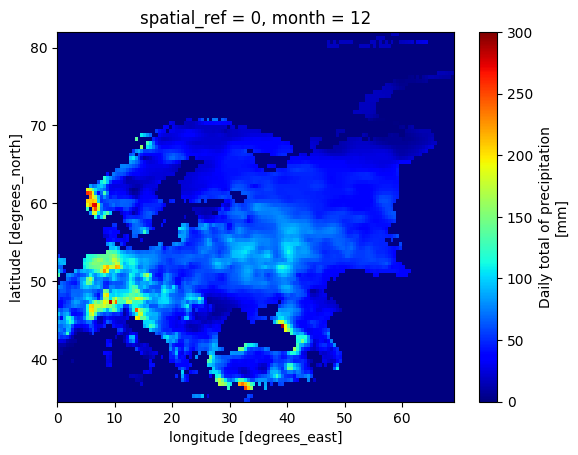

In [14]:
# make a simple visualization of one month to make sure it works as it is expected
ds2023_eu_mon.precip[11,:,:].plot(cmap='jet', vmax=300)

In [15]:
# landmasking to remove the areas that we masked
landmask = ds2023_eu.precip.sum(dim='time') > 0

In [16]:
# to create xlim and ylim for visualization
print("Longitude bounds:", ds2023_eu_mon.lon.min().item(), ds2023_eu_mon.lon.max().item())
print("Latitude bounds:", ds2023_eu_mon.lat.min().item(), ds2023_eu_mon.lat.max().item())


Longitude bounds: 0.25 68.75
Latitude bounds: 34.75 81.75


In [19]:
xlim = [ds2023_eu_mon['lon'].min().item(), ds2023_eu_mon['lon'].max().item()]
ylim = [ds2023_eu_mon['lat'].min().item(), ds2023_eu_mon['lat'].max().item()]

print(xlim)
print(ylim)


[0.25, 68.75]
[34.75, 81.75]


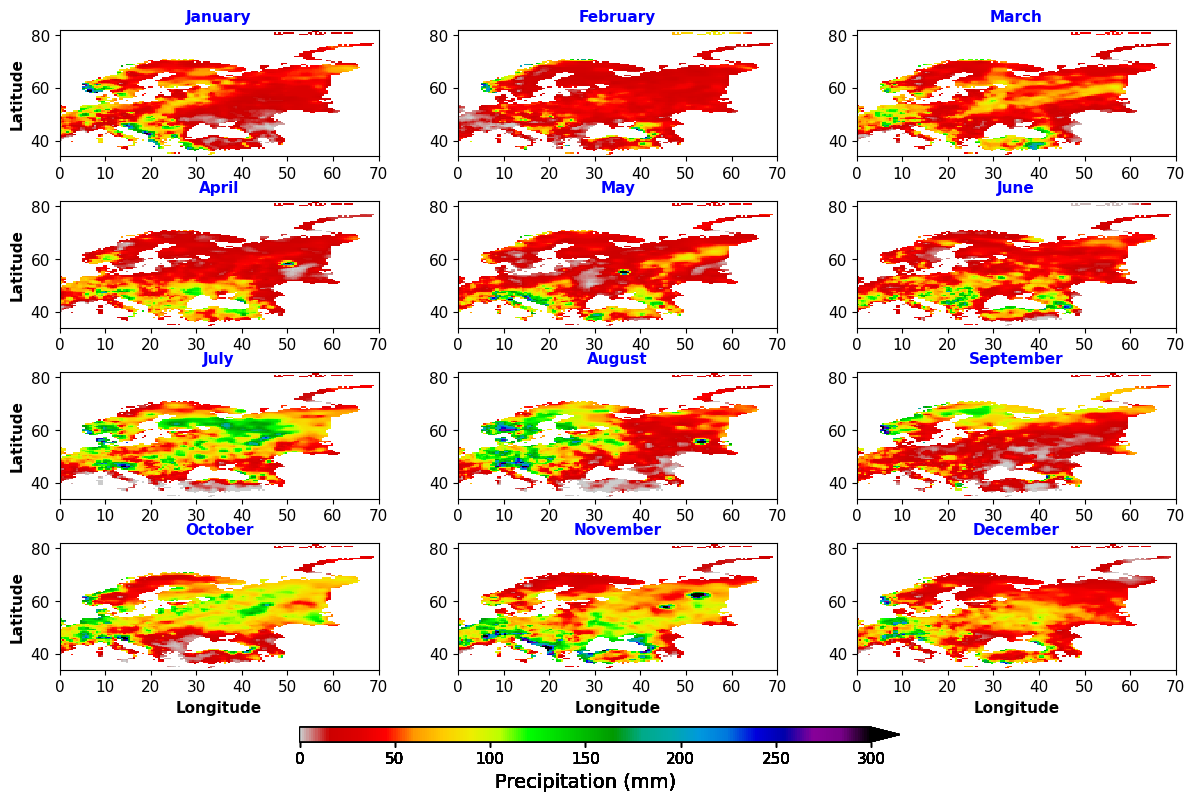

In [20]:
fig = plt.figure(figsize=[12,8], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.95, left=0.05, right=0.98,
                   wspace=0.25, hspace=0.35)

nrows = 4
ncols = 3
for i in range(1, 13):
  plt.subplot(nrows, ncols, i)
  dataplot = ds2023_eu_mon.precip[i-1, :, :].where(landmask)

  p = plt.pcolormesh(ds2023_eu_mon.lon, ds2023_eu_mon.lat, dataplot,
                     vmax=300, vmin=0, cmap = 'nipy_spectral_r')
  
  plt.xlim([ 0, 70])
  plt.ylim([34, 82])
  plt.title(calendar.month_name[dataplot.month.values], fontsize=11, fontweight='bold', color='b')

  plt.xticks(fontsize=11)
  plt.yticks(fontsize=11)

  if i % ncols == 1:
    plt.ylabel('Latitude', fontsize=11, fontweight='bold')

  if i > ncols*(nrows-1):
    plt.xlabel('Longitude', fontsize=11, fontweight='bold')

  cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
  cb = plt.colorbar(cax=cax, orientation='horizontal', extend='max')
  cb.ax.tick_params(labelsize=11)
  cb.set_label(label='Precipitation (mm)', color='k', size=14)

  plt.savefig('Fig_prec_eu_mon_2023.png', format='png', dpi=300)
